In [2]:
%pip install python-magic-bin==0.4.14 augly albumentations torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [248]:
import augly.image as ai
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from albumentations import ImageOnlyTransform
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import random
from augly.image import transforms
import os


class OverlayText(A.ImageOnlyTransform):
    def __init__(self, text, position=(0, 0), font_size=20, font_color=(255, 255, 255), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.text = text
        self.position = position
        self.font_size = font_size
        self.font_color = font_color

    def apply(self, image, **params):
        # Преобразуем изображение в формат PIL
        image_pil = Image.fromarray(image)

        # Создаем объект для рисования
        draw = ImageDraw.Draw(image_pil)

        # Загружаем шрифт
        font = ImageFont.truetype("arial.ttf", size=int(self.font_size)) # Замените на свой шрифт, если нужно

        # Добавляем текст на изображение
        draw.text(self.position, self.text, font=font, fill=self.font_color)

        # Преобразуем обратно в формат NumPy
        return np.array(image_pil)
    

class OverlayImage(A.ImageOnlyTransform): 
    def __init__(self, overlay_img, opacity=1.0, overlay_size=(1.0,1,0), overlay_position=(0, 0), p=1.0, always_apply=False):
        super().__init__(always_apply, p)  # Correctly initialize the parent class
        self.overlay_img = Image.open(overlay_img).convert("RGBA")
        self.opacity = opacity
        self.overlay_size = overlay_size
        self.overlay_position = overlay_position

    def apply(self, image, **params):

        image_pil = Image.fromarray(image).convert("RGBA")
        overlay_pil = self.overlay_img.resize((int(image_pil.width * self.overlay_size[0]), 
                                                int(image_pil.height * self.overlay_size[1])))

        combined = Image.new("RGBA", image_pil.size)
        
        combined.paste(image_pil, (0, 0))

        overlay_position = (random.randint(0, int(image_pil.size[0]-overlay_pil.size[0])), 
                            random.randint(0, int(image_pil.size[1]-overlay_pil.size[1])))
        overlay_pil.putalpha(int(255 * self.opacity)) 
        combined.paste(overlay_pil, overlay_position, overlay_pil.split()[3])

        return np.array(combined.convert("RGB"))



In [249]:


class RandomCompose(A.Compose):

    def __init__(self, transforms, bbox_params=None, keypoint_params=None, additional_targets=None, p=1.0,
                 shuffle=True):
        super().__init__(transforms, bbox_params, keypoint_params, additional_targets, p)
        self.shuffle = shuffle

    def __call__(self, *args, force_apply=False, **data):
        if self.shuffle:
            random.shuffle(self.transforms)
        return super().__call__(*args, force_apply=False, **data)


class BaseTransform(ImageOnlyTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(BaseTransform, self).__init__(always_apply, p)

    def apply(self, image, **params):
        image = self._array2img(image)
        return np.array(self._transform(image))

    def get_transform_init_args_names(self):
        return ()

    @staticmethod
    def _array2img(image):
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        return image

    def _transform(self, image):
        return



class CropAndPad(BaseTransform):
    def _transform(self, image):
        return pad(image)
    
class InvertColors(BaseTransform):
    def _transform(self, image):
        return 255 - np.array(image)
    

def pad(img, seed=None, **kwargs):
    np.random.seed(seed)
    axis = np.random.uniform(0.0, 0.3, size=2)
    x_pos, y_pos = axis[0], axis[1]

    np.random.seed(seed)
    rgb = np.random.randint(0, 255, size=3)
    r, g, b = rgb
    img = transforms.Pad(w_factor=x_pos, h_factor=y_pos, color=(r, g, b), p=1.0)(img)  # 0.1 - 0.3
    return np.array(img)

def get_all_files(directory):
        all_files = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                all_files.append(os.path.join(root, file))
        return all_files

def img_augmentations(img_path, aug_materials:list, width=256, pipeline_type='hard', crop=0.5):

    
    all_gifs, all_watermarks, all_texts = aug_materials
    
    
    hard_pipelines = A.Compose([
            RandomCompose([
                    
                        
                    A.OneOf([
                       OverlayText(text=random.choice(all_texts),
                                    font_size=random.randint(40,70),
                                    position=(random.randint(0,1080/2), random.randint(0,1920/2)),
                                    font_color=(random.randint(100,255),random.randint(100,255),random.randint(100,255)), 
                                    p=1),
                       
                       OverlayImage(overlay_img=random.choice(all_gifs),
                                    overlay_size=(random.uniform(0.2,0.5),
                                                    random.uniform(0.2,0.5)),
                                    overlay_position=(0,0),
                                    opacity=random.uniform(0.8, 1),
                                    p=1),

                       OverlayImage(overlay_img=random.choice(all_watermarks),
                                    overlay_size=(random.uniform(0.2,0.5),
                                                    random.uniform(0.2,0.5)),
                                    overlay_position=(0,0),
                                    opacity=random.uniform(0.8, 1),
                                    p=1),
                        OverlayText(text='Yappy',
                                    font_size=random.randint(40,70),
                                    position=(random.randint(0,1080/2), random.randint(0,1920/2)),
                                    font_color=(random.randint(0,150),255,255), 
                                    p=1),                     
                    ], p=1),

                    A.OneOf([
                        A.OneOf([
                            A.HorizontalFlip(p=1),
                            A.VerticalFlip(p=1),
                            A.RandomRotate90(p=1),
                            A.RandomResizedCrop(width, width, scale=(crop, 0.4), p=1),
                        ], p=0.3),

                        A.OneOf([
                            A.GaussNoise(var_limit=(0.01,0.02), p=1),
                            A.GaussianBlur(p=1),
                            A.RandomScale(p=1),
                            A.Perspective(p=1),
                        ], p=0.3),
                        
                        
                        # # OverlayEmoji(p=0.1),
                
                        A.OneOf([
                            CropAndPad(p=1),
                            A.CropAndPad(percent=(-0.4, 0.4), p=1)
                        ], p=0.3),
                        A.OneOf([
                            InvertColors(p=1),
                            A.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2, p=1),
                            A.RandomBrightnessContrast((-0.2, 0.1), p=1),
                            A.ToGray(p=1),
                            A.HueSaturationValue(p=1),
                        ], p=1),
                                # RandomOverlayImages(arg_lmdb_path, lmdb_size, width, p=mixup),
                                # RandomOverlayCorners(p=0.1),
                                #A.Rotate(45, border_mode=0, p=0.1)
                        ])
            ], shuffle=True, p=1),

                        A.Resize(256, 256, always_apply=True),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True),
                        ToTensorV2(),
                    
    ])
               


    easy_pipelines =  A.Compose([
                        A.OneOf([
                            A.HorizontalFlip(p=1),
                            A.VerticalFlip(p=1),
                            A.RandomResizedCrop(width, width, scale=(0.5, 1), p=1),
                            A.GaussNoise(p=1),
                        ]),    
                        A.Resize(256, 256, always_apply=True),
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True),
                        ToTensorV2()])
    

    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)
    img = np.array(img)
    
    if pipeline_type=='hard':

        img = hard_pipelines(image=img)['image']

    elif pipeline_type=='easy':
        img = easy_pipelines(image=img)['image']
    
    img = np.transpose(img, (1,2,0))

    plt.imshow(img)

    return img


In [250]:
path_to_gifs = "D:/DigitalAvatar_vseros24_private/data/gifs_to_imgs"
path_to_watermarks = "D:/DigitalAvatar_vseros24_private/data/watermarks"

# Пример использования
all_gifs = get_all_files(path_to_gifs)
all_watermarks = get_all_files(path_to_watermarks)
all_texts = [
    'YOUTUBE',
    'ABOBA',
    'TIKTOK',
    'RUTUBE',
    'READY',
    'SUBSCRIBE',
    'LIKE',
    'LIKE AND SUBSCRIBE',
    'BEST VIDEO EVER'
] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


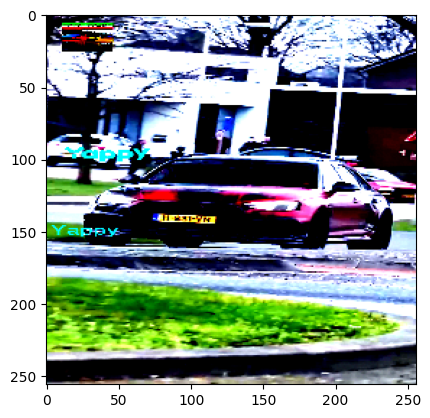

In [260]:
path = "D:/DigitalAvatar_vseros24_private/keyframe_extraction/keyframes/output_002.png"
out_img = img_augmentations(path,  aug_materials=[all_gifs, all_watermarks, all_texts], pipeline_type='hard')